# CP321 Project - Analysis of Ontario Hospitalization & ICU Data through the COVID Pandemic
Jake Watts - 151477490
Evan Parisotto - 

## Introduction
In the more than four years since the beginning of the COVID-19 pandemic, Ontario's hospitals have been met with cycles of inundation related to the virus and its variants. Here, it is our aim to utilize a [dateset from the Ontario Ministry of Health](https://data.ontario.ca/dataset/covid-19-cases-in-hospital-and-icu-by-ontario-health-region) to explore questions about how the load experienced by the province's hospitals has been distributed (namely, how it has been distributed across different Ontario Health Regions, characterized by clear geographic boundaries as well as approximate population numbers), and been affected by key events, like the emergence of new variants and vaccines. Through the lens of this analysis, we seek to understand not only the patterns and pressures of the past four years but also to identify trends and seasonal fluctuations that could guide future healthcare strategies.

## Motivation
Nothin yet!

## Data Set Description

### [Data Source - COVID-19 Cases in Hospital and ICU by Ontario Health Region](https://data.ontario.ca/dataset/covid-19-cases-in-hospital-and-icu-by-ontario-health-region)
To focus our exploration of the data, we elected to prioritize the `hospitalizations` and `icu_current_covid` response variables from this dataset. The daily numbers were used for the time series visualizations, and grouped by the 

| CSV Field           | Description                                                                                   |
|---------------------|-----------------------------------------------------------------------------------------------|
| `date`              | Date                                                                                          |
| `oh_region`         | Ontario Health Region                                                                                     |
| `hospitalizations`  | Current hospitalizations with COVID-19                                                        |
| `icu_crci_total`    | Current patients in Intensive Care Units (ICUs) due to COVID-related critical illness         |
| `icu_current_covid` | Patients in Intensive Care Units (ICUs) testing positive for COVID                            |
| `icu_former_covid`  | Current patients in Intensive Care Units (ICUs) no longer testing positive for COVID          |
| `icu_crci_total_vented` | Current patients in Intensive Care Units (ICUs) on ventilators due to COVID-related critical illness |
| `icu_current_covid_vented` | Current patients in Intensive Care Units (ICUs) on ventilators testing positive for COVID   |
| `icu_former_covid_vented` | Current patients in Intensive Care Units (ICUs) on ventilators no longer testing positive for COVID |

### [Ontario Health Region Boundaries](https://data.ontario.ca/dataset/ontario-s-health-region-geographic-data)
| Column Name   | Data Type | Description                                 |
|---------------|-----------|---------------------------------------------|
| `OBJECTID`    | int64     | Unique identifier for each record           |
| `OH_Region_`  | object    | Code for Ontario Health Region              |
| `OH_Name`     | object    | English name for Ontario Health Region      |
| `OH_Name_FR`  | object    | French name for Ontario Health Region       |
| `geometry`    | object    | Geometric data representing the region's boundaries in MULTIPOLYGON format |


### [Ontario Health Region Populations](https://www.ontariohealth.ca/about-us/our-programs/ontario-health-regions)
No dynamic data that parallels the main hospitalization dataset could be found, so in lieu we're using the official static population numbers reported for each region from Ontario Health's website.

### [Key Dates - COVID-19 vaccination in Canada](https://en.wikipedia.org/wiki/COVID-19_vaccination_in_Canada)
This article was used to determine the dates that new vaccines became available through the pandemic.

### [Variant Dates](https://en.wikipedia.org/wiki/SARS-CoV-2_Omicron_variant)
This article was used to determine the dates the the different variants of the virus emerged.

### Source Links
- [Data Source - COVID-19 Cases in Hospital and ICU by Ontario Health Region](https://data.ontario.ca/dataset/covid-19-cases-in-hospital-and-icu-by-ontario-health-region)
- [Vaccine Dates - COVID-19 vaccination in Canada](https://en.wikipedia.org/wiki/COVID-19_vaccination_in_Canada)
- [Variant Dates](https://en.wikipedia.org/wiki/SARS-CoV-2_Omicron_variant)
- [Ontario Health Region Boundaries](https://data.ontario.ca/dataset/ontario-s-health-region-geographic-data)
- [Ontario Health Region Populations](https://www.ontariohealth.ca/about-us/our-programs/ontario-health-regions)

### Questions
1. How have hospitalizations and ICU admissions due to COVID-19 in Ontario fluctuated over time in relation to key events like the emergence of new virus variants and the rollout of vaccines?
2. What are the long-term trends in COVID-19 hospitalizations and ICU admissions in Ontario, and is there a discernible seasonal pattern to these metrics?
3. How is the burden of COVID-19 hospitalizations and ICU admissions distributed across the different health regions of Ontario?
4. When accounting for population, which Ontario health regions have been most and least affected by COVID-19 in terms of hospitalizations and ICU admissions?

## Data Processing

In [19]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
BLUE = '#3a86ff'
RED = '#780000'
GREEN = '#127823'

key_dates = {
    '2020-12-01': 'Emergence of Alpha variant',
    '2021-05-01': 'Emergence of Beta variant',
    '2021-08-01': 'Emergence of Gamma variant',
    '2021-11-01': 'Emergence of Delta variant',
    '2022-02-01': 'Emergence of Omicron variant',
    '2020-12-14': 'First Pfizer–BioNTech vaccine administered in Canada',
    '2020-12-23': 'Health Canada authorizes Moderna vaccine',
    '2021-02-26': 'Oxford–AstraZeneca vaccine authorized by Health Canada',
    '2021-03-05': 'Janssen (Johnson & Johnson) vaccine authorized by Health Canada',
    '2021-05-05': 'Pfizer vaccine authorized for adolescents 12 to 15 in Canada',
    '2021-09-16': 'Moderna and Pfizer vaccines receive full approval for use in individuals aged 12 and older',
    '2021-11-19': 'Health Canada approves Pfizer-BioNTech vaccine for children aged 5 to 11',
    '2021-12-14': 'One year since the first COVID-19 vaccine was administered in Canada',
    '2022-07-14': 'Health Canada approves Moderna vaccine for children aged 6 months to 5 years',
    '2022-09-01': 'Moderna bivalent vaccine targeting original and Omicron BA.1 variant authorized by Health Canada',
    '2022-10-07': 'Pfizer bivalent vaccine targeting Omicron BA.4 and BA.5 subvariants approved by Health Canada',
    '2023-09-12': 'Health Canada authorizes a new Moderna vaccine based on Omicron XBB.1.5 subvariant',
}

# Load primary dataset
df = pd.read_csv("data/region_hospital_icu_covid_data.csv")

# Convert to datetime
df["date"] = pd.to_datetime(df["date"])

# Set date as the dataframe's index
df.set_index('date', inplace=True)

integer_columns = ['icu_current_covid', 'icu_current_covid_vented', 
               'hospitalizations', 'icu_crci_total', 'icu_crci_total_vented', 
               'icu_former_covid', 'icu_former_covid_vented']

# Convert all integer columns to int64
for column in integer_columns:
    df[column] = pd.to_numeric(df[column], errors="coerce").fillna(0).astype("int64")

# These are the key response variables that will be investigated throughout the visualizations
key_variables = ['hospitalizations', 'icu_current_covid']
key_variable_titles = {'hospitalizations': 'Total Hospitalizations', 'icu_current_covid': 'Total ICU Visits'}

# Rename the 'oh_region' column in df to match the 'OH_Name' in gdf (for the geospatial visualization later)
df.rename(columns={'oh_region': 'OH_Name'}, inplace=True)
df['OH_Name'] = df['OH_Name'].str.title()

# Get a list of regions
regions = df["OH_Name"].unique()

# From [Ontario Health Region Populations](https://www.ontariohealth.ca/about-us/our-programs/ontario-health-regions)
populations = {'Central': 5000000, 'East': 3700000, 'North East': 557000, 'North West': 232299, 'Toronto': 1400000, 'West': 4000000}
populations_df = pd.DataFrame(list(populations.items()), columns=['OH_Name', 'population'])

# This dataframe has total population, hospitalizations, and icu_current_covid counts for each region.
aggregated_df = df.groupby('OH_Name')[key_variables].sum().reset_index()
aggregated_df = aggregated_df.merge(populations_df, on='OH_Name')

# Setup dataframes for the geospatial visualizations
gdf = gpd.read_file('data/ontario_health_region_boundaries.shp')
hospitalizations_df = df.groupby('OH_Name')['hospitalizations'].sum().reset_index()

merged_gdf = gdf.merge(hospitalizations_df, on='OH_Name')
merged_gdf = merged_gdf.merge(populations_df, on='OH_Name')
merged_gdf['hospitalization_to_population'] = merged_gdf['hospitalizations'] / merged_gdf['population']

merged_gdf = gdf.merge(aggregated_df, on='OH_Name')
merged_gdf['hospitalization_to_population'] = merged_gdf['hospitalizations'] / merged_gdf['population']
merged_gdf['icu_to_population'] = merged_gdf['icu_current_covid'] / merged_gdf['population']

### Question 1: Time Series - Key Date Annotations

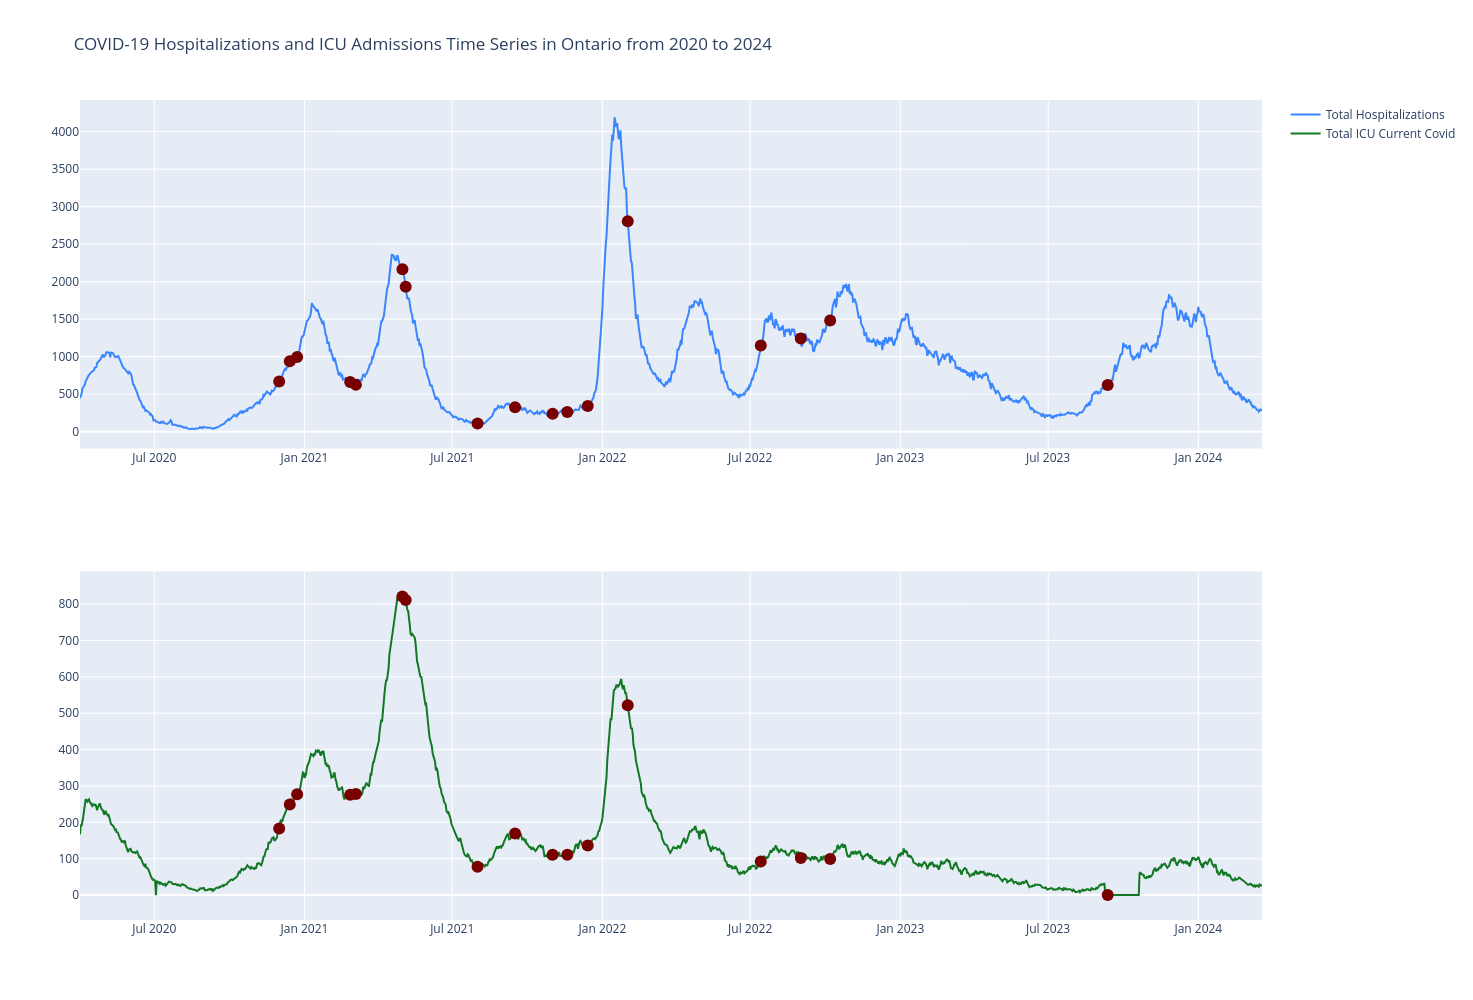

In [21]:
# Get daily totals for each region
total_hospitalizations = df.groupby('date').sum()['hospitalizations'].reset_index()
total_icu = df.groupby('date').sum()['icu_current_covid'].reset_index()

# Create the subplots for the two time series
fig = make_subplots(rows=2, cols=1)

# Add the total hospitalizations time series to the first row
fig.add_trace(
    go.Scatter(
        x=total_hospitalizations["date"],
        y=total_hospitalizations["hospitalizations"],
        mode="lines",
        name="Total Hospitalizations",
        line=dict(color=BLUE),
    ),
    row=1,
    col=1,
)

# Add the total ICU current covid cases time series to the second row
fig.add_trace(
    go.Scatter(
        x=total_icu["date"],
        y=total_icu["icu_current_covid"],
        mode="lines",
        name="Total ICU Current Covid",
        line=dict(color=GREEN),
    ),
    row=2,
    col=1,
)

# Loop through the key_dates and add annotations
for key_date, description in key_dates.items():
    # Add markers and annotations for hospitalizations plot
    if pd.to_datetime(key_date) in total_hospitalizations["date"].values:
        # Extract the value for the key date
        key_date_val = total_hospitalizations.loc[
            total_hospitalizations["date"] == pd.to_datetime(key_date),
            "hospitalizations",
        ].iloc[0]

        # Add a marker for the key date
        fig.add_trace(
            go.Scatter(
                x=[key_date],
                y=[key_date_val],
                mode="markers",
                marker=dict(size=12, color=RED),
                name="Key Date",
                text=[description],
                textposition="top center",
                showlegend=False,
            ),
            row=1,
            col=1,
        )

    # Add markers and annotations for ICU plot
    if pd.to_datetime(key_date) in total_icu["date"].values:
        # Extract the value for the key date
        key_date_val = total_icu.loc[
            total_icu["date"] == pd.to_datetime(key_date), "icu_current_covid"
        ].iloc[0]

        # Add a marker for the key date
        fig.add_trace(
            go.Scatter(
                x=[key_date],
                y=[key_date_val],
                mode="markers",
                marker=dict(size=12, color=RED),
                name="Key Date",
                text=[description],
                textposition="top center",
                showlegend=False,
            ),
            row=2,
            col=1,
        )

# Update the layout of the figure
fig.update_layout(
    height=1000,
    title_text="COVID-19 Hospitalizations and ICU Admissions Time Series in Ontario from 2020 to 2024",
)
fig.show()


### Question 2: Time Series - Trend & Seasonality

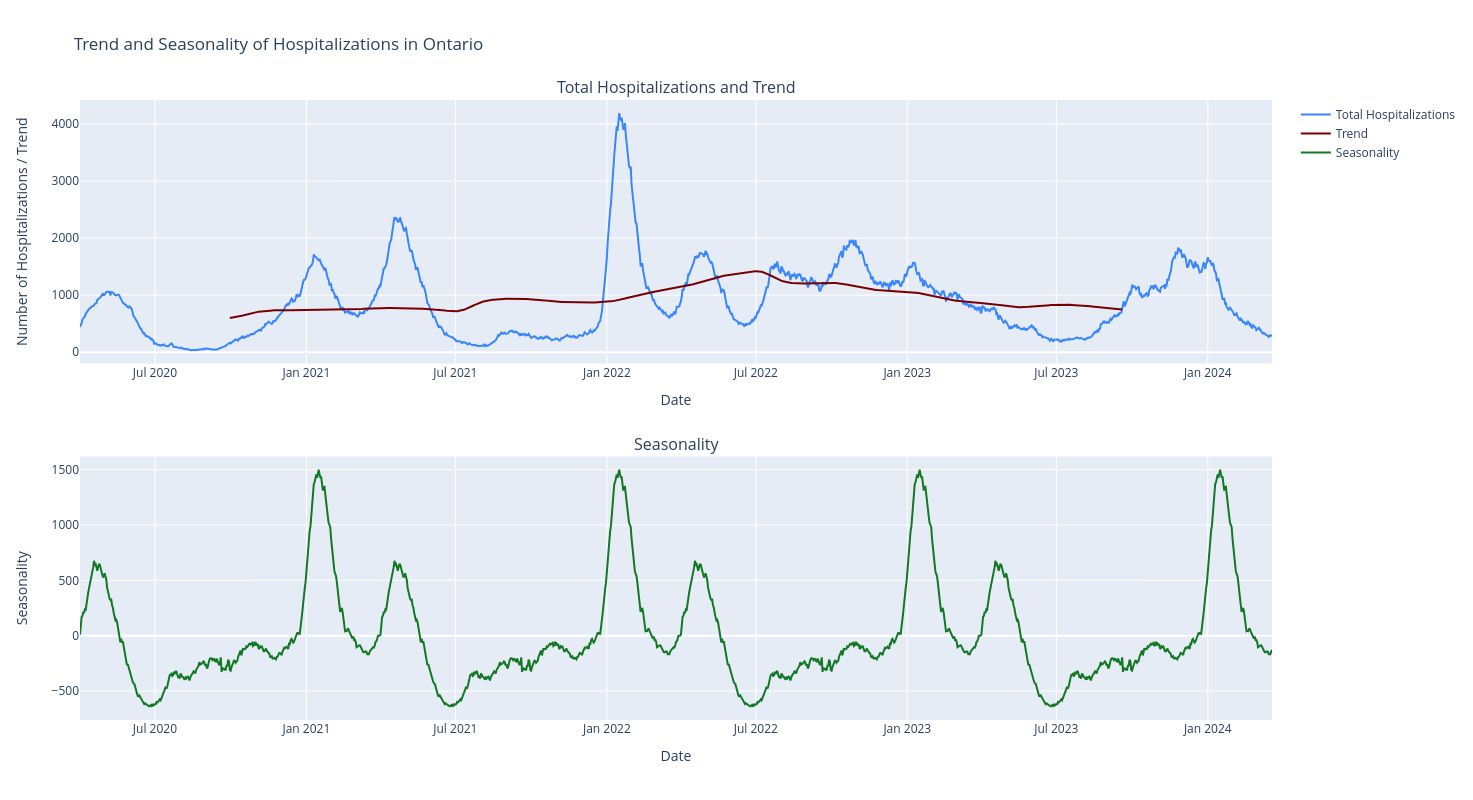

In [22]:
total_ontario_hospitalizations = df.groupby('date')['hospitalizations'].sum()

decomposition = seasonal_decompose(total_ontario_hospitalizations, model='additive', period=365)

trend = decomposition.trend
seasonality = decomposition.seasonal

# Create a figure with subplots - 2 rows, 1 column
fig = make_subplots(rows=2, cols=1, subplot_titles=('Total Hospitalizations and Trend', 'Seasonality'),
                    vertical_spacing=0.15)

# Add the total hospitalizations trace to the first subplot
fig.add_trace(go.Scatter(x=total_ontario_hospitalizations.index,
                         y=total_ontario_hospitalizations,
                         mode='lines',
                         name='Total Hospitalizations',
                         line=dict(color=BLUE)),
              row=1, col=1)

# Add the trend trace to the first subplot
fig.add_trace(go.Scatter(x=trend.index, y=trend,
                         mode='lines',
                         name='Trend',
                         line=dict(color=RED)),
              row=1, col=1)

# Add the seasonality trace to the second subplot
fig.add_trace(go.Scatter(x=seasonality.index, y=seasonality,
                         mode='lines',
                         name='Seasonality',
                         line=dict(color=GREEN)),
              row=2, col=1)

# Update layout to enhance readability
fig.update_layout(height=800, 
                  title_text='Trend and Seasonality of Hospitalizations in Ontario')
fig.update_xaxes(title_text='Date', row=1, col=1)
fig.update_xaxes(title_text='Date', row=2, col=1)
fig.update_yaxes(title_text='Number of Hospitalizations / Trend', row=1, col=1)
fig.update_yaxes(title_text='Seasonality', row=2, col=1)

# Show the figure
fig.show()


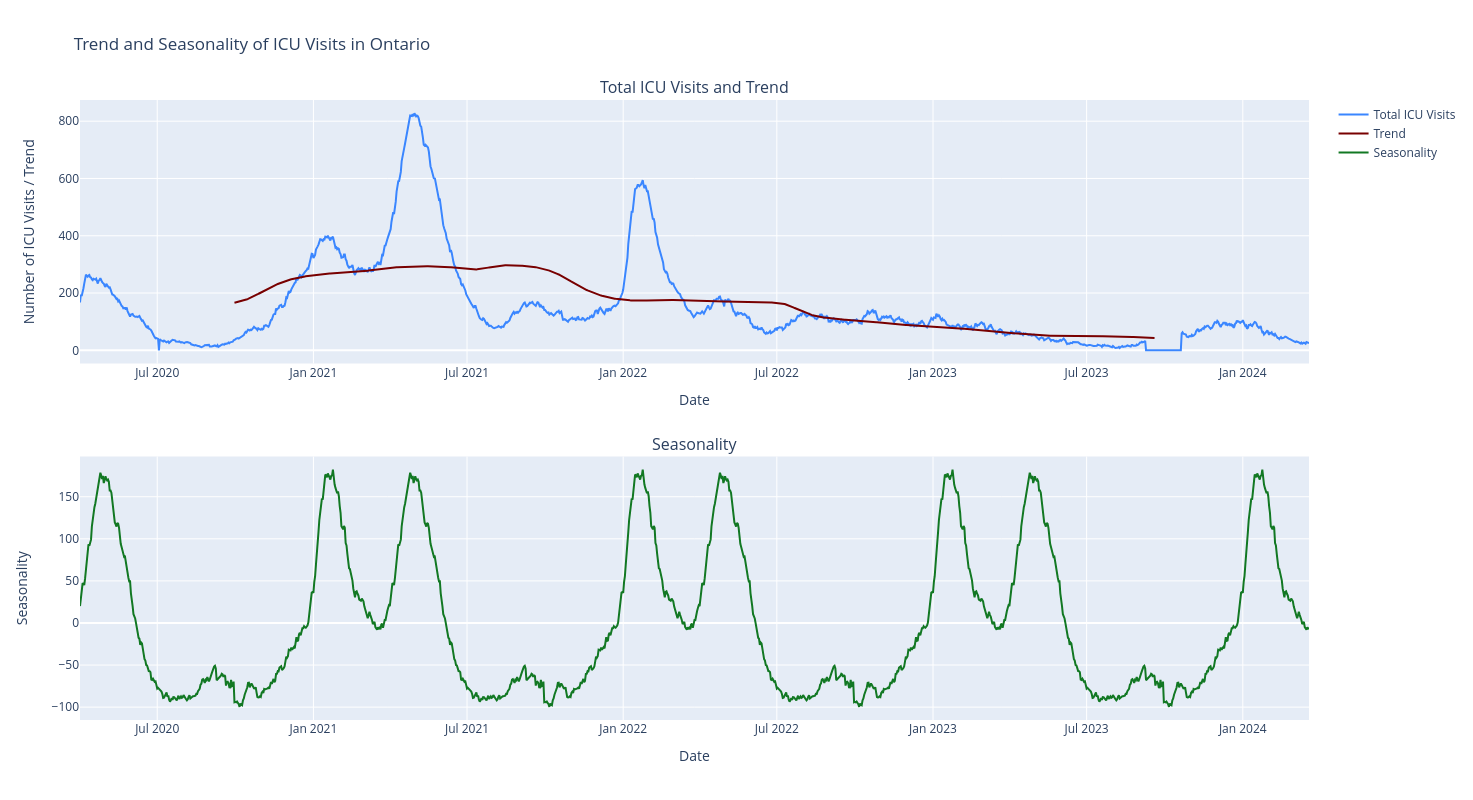

In [23]:
# Assuming 'df' is your DataFrame and 'date' is the index
total_ontario_icu = df.groupby('date')['icu_current_covid'].sum()

# Perform seasonal decomposition
# The 'period' parameter should correspond to the dataset's periodicity (e.g., approximately yearly if 'period=365')
decomposition_icu = seasonal_decompose(total_ontario_icu, model='additive', period=365)

trend_icu = decomposition_icu.trend
seasonality_icu = decomposition_icu.seasonal

# Create a figure with subplots - 2 rows, 1 column
fig_icu = make_subplots(rows=2, cols=1, subplot_titles=('Total ICU Visits and Trend', 'Seasonality'),
                    vertical_spacing=0.15)

# Add the total ICU visits trace to the first subplot
fig_icu.add_trace(go.Scatter(x=total_ontario_icu.index,
                             y=total_ontario_icu,
                             mode='lines',
                             name='Total ICU Visits',
                             line=dict(color=BLUE)),
                  row=1, col=1)

# Add the trend trace to the first subplot
fig_icu.add_trace(go.Scatter(x=trend_icu.index, y=trend_icu,
                             mode='lines',
                             name='Trend',
                             line=dict(color=RED)),
                  row=1, col=1)

# Add the seasonality trace to the second subplot
fig_icu.add_trace(go.Scatter(x=seasonality_icu.index, y=seasonality_icu,
                             mode='lines',
                             name='Seasonality',
                             line=dict(color=GREEN)),
                  row=2, col=1)

# Update layout to enhance readability
fig_icu.update_layout(height=800, 
                  title_text='Trend and Seasonality of ICU Visits in Ontario')
fig_icu.update_xaxes(title_text='Date', row=1, col=1)
fig_icu.update_xaxes(title_text='Date', row=2, col=1)
fig_icu.update_yaxes(title_text='Number of ICU Visits / Trend', row=1, col=1)
fig_icu.update_yaxes(title_text='Seasonality', row=2, col=1)

# Show the figure
fig_icu.show()

### Question 3: Pie Charts - Hospital Load by Region

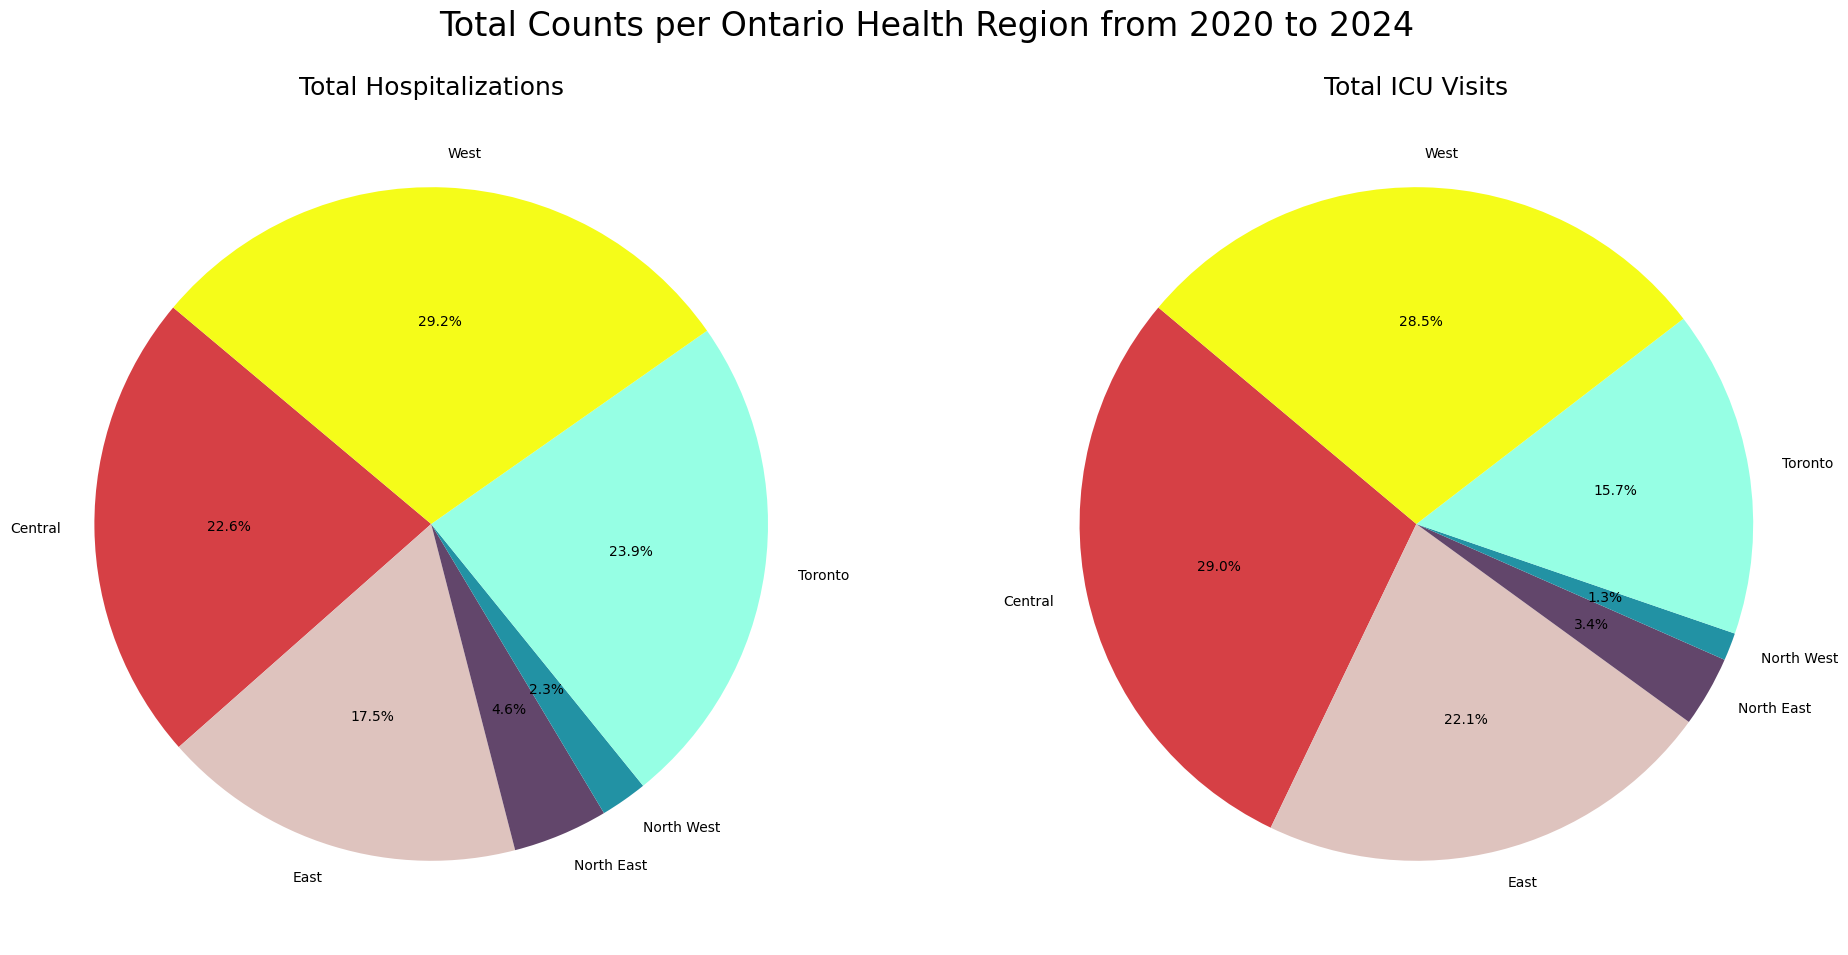

In [24]:
# I decided to make a custom color map for funzies
region_colors = {
    'Central': '#D64045',
    'East': '#DEC3BE',
    'North East': '#62466B',
    'North West': '#2292A4',
    'Toronto': '#96FFE4',
    'West': '#f5fc19',
}

# Order the colors in the same order as the regions appear in 'aggregated_df'
colors = [region_colors[region] for region in aggregated_df['OH_Name']]

# Create subplots: one row and two columns (since you only have two key variables)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figsize to fit your screen or preferences

# Generate a pie chart for each key variable
for i, var in enumerate(key_variables):
    axes[i].pie(aggregated_df[var], labels=aggregated_df['OH_Name'], autopct='%1.1f%%', startangle=140, colors=colors)
    axes[i].set_title(key_variable_titles[var], fontsize=18)  # Use the custom title from the dictionary

# Add a central title to the figure
fig.suptitle('Total Counts per Ontario Health Region from 2020 to 2024', fontsize=24)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()


### Question 4: Choropleth Map - Relative Hospitalization & ICU Load by Region

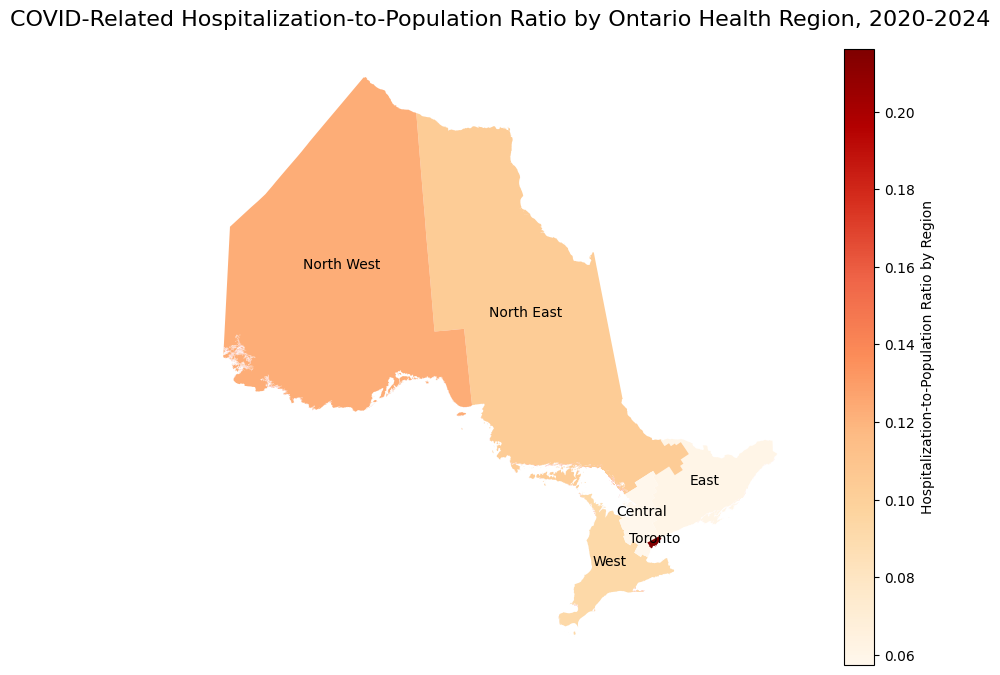

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the choropleth map with the new ratio column
merged_gdf.plot(column='hospitalization_to_population',
                ax=ax,
                legend=True,
                legend_kwds={'label': "Hospitalization-to-Population Ratio by Region"},
                cmap='OrRd')

ax.axis('off')
ax.set_title('COVID-Related Hospitalization-to-Population Ratio by Ontario Health Region, 2020-2024', fontsize=16)

# Add region labels to the map
for idx, row in merged_gdf.iterrows():
    plt.annotate(text=row['OH_Name'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center')

plt.show()

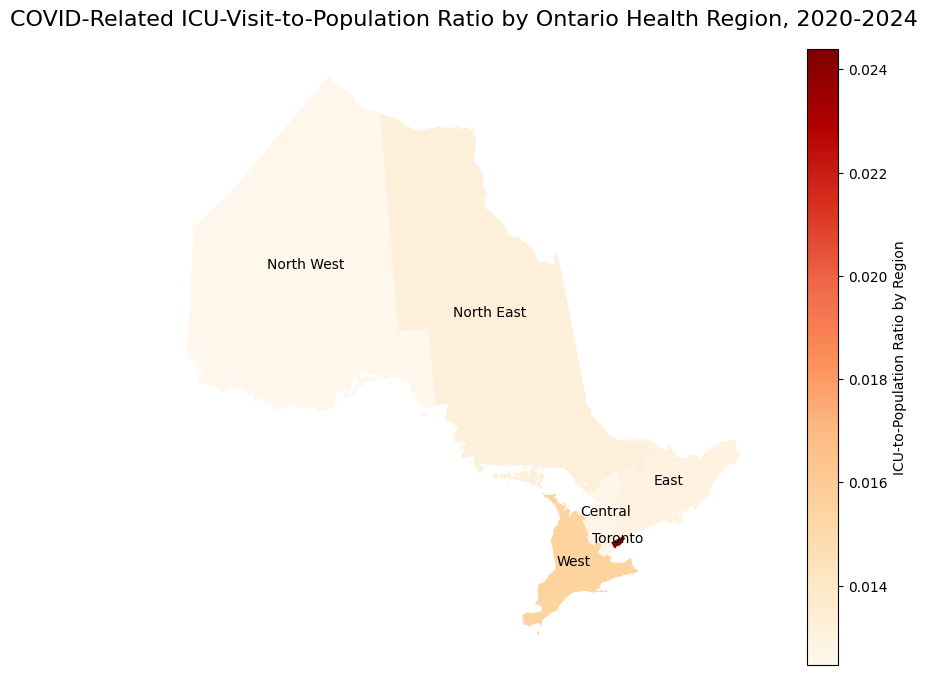

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the choropleth map with the new ratio column
merged_gdf.plot(column='icu_to_population',
                ax=ax,
                legend=True,
                legend_kwds={'label': "ICU-to-Population Ratio by Region"},
                cmap='OrRd')

ax.axis('off')
ax.set_title('COVID-Related ICU-Visit-to-Population Ratio by Ontario Health Region, 2020-2024', fontsize=16)

# Add region labels to the map
for idx, row in merged_gdf.iterrows():
    plt.annotate(text=row['OH_Name'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center')

plt.show()

## Conclusion